In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import os
import shutil
import pandas as pd

Creating subdirectories within the cropped_image directory so that we can extract the class information from the csv and parse it together with the cropped images.  
This is necessary for the keras 

In [2]:
# defining somoe parameters for the loader:
batch_size = 32
# image size is predetermined through the face_recognition filter
img_height = 224
img_width = 224

# Read the CSV file containing image filenames and their corresponding class labels
csv_file = 'train.csv'
data = pd.read_csv(csv_file)

# Define the main directory where the images will be stored
new_subdir = 'subdir_224'
os.makedirs(new_subdir, exist_ok=True)

# Iterate over each row in the CSV file
for index, row in data.iterrows():
    image_filename = row['file_name']  # Assuming 'filename' is the column containing image filenames
    class_label = row['category']  # Assuming 'class' is the column containing class labels
    
    # Create subdirectory for the class if it doesn't exist
    class_directory = os.path.join(new_subdir, str(class_label))
    os.makedirs(class_directory, exist_ok=True)
    
    # Move or copy the image to the corresponding class subdirectory
    image_source = 'cropped_224/' + image_filename  # Adjust the path as needed
    if not os.path.exists(image_source):
        print(f"Image file '{image_filename}' not found. Skipping...")
        continue
    image_destination = os.path.join(class_directory, image_filename)
    shutil.copy(image_source, image_destination)  # Use shutil.move() for moving instead of copying

Image file '17.jpg' not found. Skipping...
Image file '44.jpg' not found. Skipping...
Image file '70.jpg' not found. Skipping...
Image file '146.jpg' not found. Skipping...
Image file '163.jpg' not found. Skipping...
Image file '186.jpg' not found. Skipping...
Image file '223.jpg' not found. Skipping...
Image file '267.jpg' not found. Skipping...
Image file '310.jpg' not found. Skipping...
Image file '338.jpg' not found. Skipping...
Image file '380.jpg' not found. Skipping...
Image file '509.jpg' not found. Skipping...
Image file '568.jpg' not found. Skipping...
Image file '574.jpg' not found. Skipping...
Image file '598.jpg' not found. Skipping...
Image file '599.jpg' not found. Skipping...
Image file '613.jpg' not found. Skipping...
Image file '745.jpg' not found. Skipping...
Image file '766.jpg' not found. Skipping...
Image file '805.jpg' not found. Skipping...
Image file '844.jpg' not found. Skipping...
Image file '873.jpg' not found. Skipping...
Image file '983.jpg' not found. Ski

Dividing the existing dataset into training and validation sets

In [15]:
subdir_small = 'subdir_small'
train_small_ds = tf.keras.utils.image_dataset_from_directory(
  subdir_small,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_small_ds = tf.keras.utils.image_dataset_from_directory(
  subdir_small,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6824 files belonging to 100 classes.
Using 5460 files for training.
Found 6824 files belonging to 100 classes.
Using 1364 files for validation.


In [16]:
class_names = train_small_ds.class_names

Configuring the dataset for cashe. I can get data from disk without having I/O becoming blocking. 

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_small_ds = train_small_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_small_ds = val_small_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data so that the the RGB values will be from 0 - 1 instead of 0 - 255

In [18]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_small_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Creating a convolution and max pooling layers

In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\Jeffz\Desktop\Purdue 2024\ECE 500\hw\mini_challenge\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# compiling the data using Adam as optimizer and cross entropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,156,612 (19.67 MB)

 Trainable params: 5,156,612 (19.67 MB)

 Non-trainable params: 0 (0.00 B)

Training the model using 30 epochs 

In [25]:
epochs=30
history = model.fit(
  train_small_ds,
  validation_data=val_small_ds,
  epochs=epochs
)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.0132 - loss: 4.6065 - val_accuracy: 0.0147 - val_loss: 4.5801
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.0346 - loss: 4.5216 - val_accuracy: 0.0433 - val_loss: 4.4789
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.0815 - loss: 4.2123 - val_accuracy: 0.0828 - val_loss: 4.2907
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.2005 - loss: 3.4504 - val_accuracy: 0.1012 - val_loss: 4.5661
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.4143 - loss: 2.4234 - val_accuracy: 0.1232 - val_loss: 5.2439
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6552 - loss: 1.3950 - val_accuracy: 0.1268 - val_loss: 6.4714
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.8352 - loss: 0.6974 - val_accuracy: 0.1246 - val_loss: 8.2863
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9090 - loss: 0.4034 

Visualize the loss and accuracy

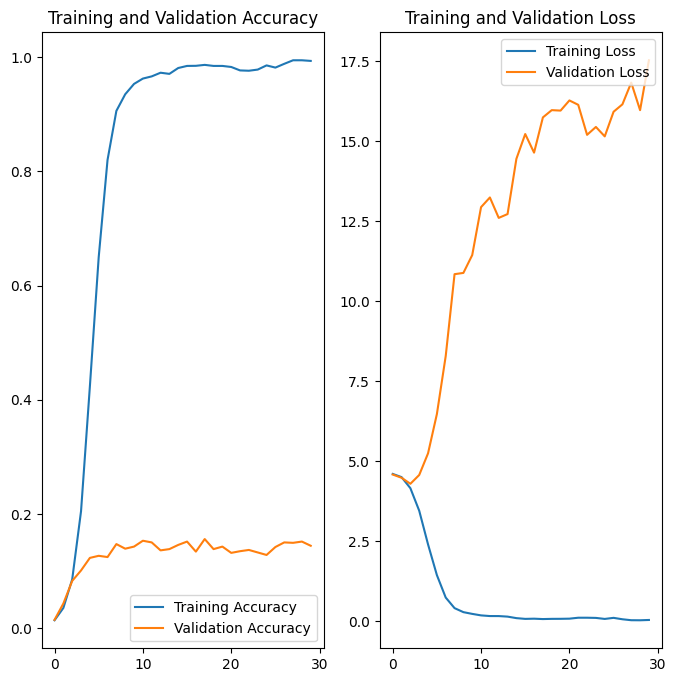

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There seems to be a lot of overfitting to the training set. Implementing data augmentation to solve the overfitting problem

In [52]:
augmented_model = keras.Sequential(
  [
    # performing data augmentation
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # adding in the convolutional and max pooling layers as usual
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
  ]
)

In [53]:
augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
augmented_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_9 (RandomFlip)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_9               │ (None, 200, 200, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 200, 200, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,469,764 (9.42 MB)

 Trainable params: 2,469,764 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# training the data
epochs = 20
history = augmented_model.fit(
  train_small_ds,
  validation_data=val_small_ds,
  epochs=epochs
)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.0065 - loss: 4.6113 - val_accuracy: 0.0110 - val_loss: 4.6046
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.0167 - loss: 4.5995 - val_accuracy: 0.0191 - val_loss: 4.5936
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0169 - loss: 4.5678 - val_accuracy: 0.0286 - val_loss: 4.5767
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0293 - loss: 4.4856 - val_accuracy: 0.0323 - val_loss: 4.4713
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.0401 - loss: 4.4233 - val_accuracy: 0.0389 - val_loss: 4.4307
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.0536 - loss: 4.3342 - val_accuracy: 0.0616 - val_loss: 4.3032
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.0607 - loss: 4.2481 - val_accuracy: 0.0667 - val_loss: 4.2484
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.0729 - loss: 4.1884 - 

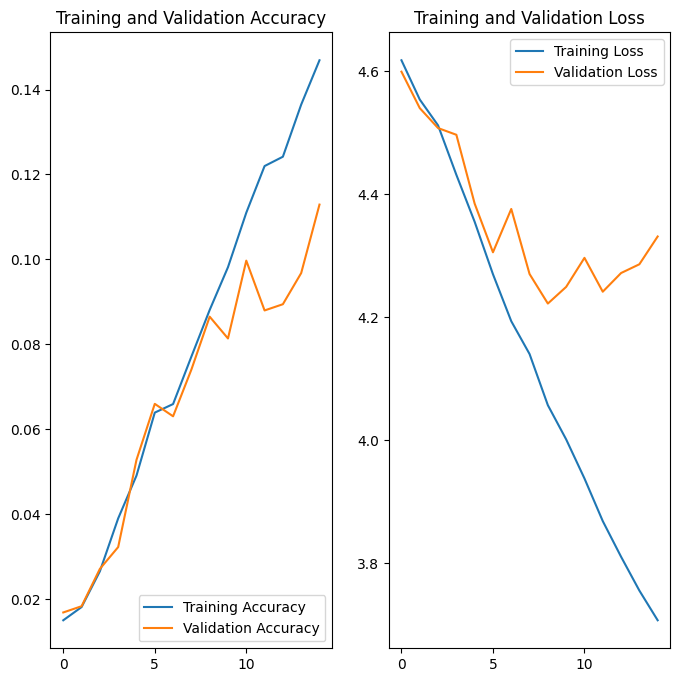

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()